
# Laplacian segmentation


This notebook implements the laplacian segmentation method of
`McFee and Ellis, 2014 <http://bmcfee.github.io/papers/ismir2014_spectral.pdf>`_,
with a couple of minor stability improvements.

Throughout the example, we will refer to equations in the paper by number, so it will be
helpful to read along.



In [1]:
# Code source: Brian McFee
# License: ISC

Imports
  - numpy for basic functionality
  - scipy for graph Laplacian
  - matplotlib for visualization
  - sklearn.cluster for K-Means




In [2]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn.cluster
import librosa
import librosa.display
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

First, we'll load in a song



In [3]:
y, sr = librosa.load('Audio/Are You That Somebody.mp3')
yI, srI = librosa.load('Audio/Are You That Somebody (Instrumental).mp3')
yA, srA = librosa.load('Audio/Are You That Somebody (Acapella).mp3')

Next, we'll compute and plot a log-power CQT



C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


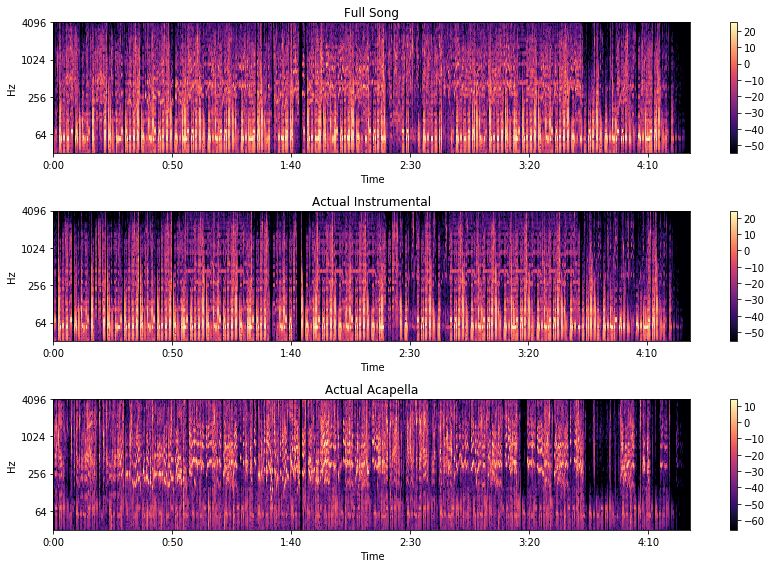

In [4]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
C = librosa.amplitude_to_db(librosa.cqt(y=y, sr=sr))

librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         x_axis='time', cmap='magma')
plt.title('Full Song')
plt.colorbar()
plt.subplot(3, 1, 2)
CI = librosa.amplitude_to_db(librosa.cqt(y=yI, sr=srI))

librosa.display.specshow(CI, y_axis='cqt_hz', sr=srI,
                         x_axis='time', cmap='magma')
plt.title('Actual Instrumental')
plt.colorbar()
plt.subplot(3, 1, 3)
CA = librosa.amplitude_to_db(librosa.cqt(y=yA, sr=srA))

librosa.display.specshow(CA, y_axis='cqt_hz', sr=srA,
                         x_axis='time', cmap='magma')
plt.title('Actual Acapella')
plt.colorbar()
plt.tight_layout()

To reduce dimensionality, we'll beat-synchronous the CQT



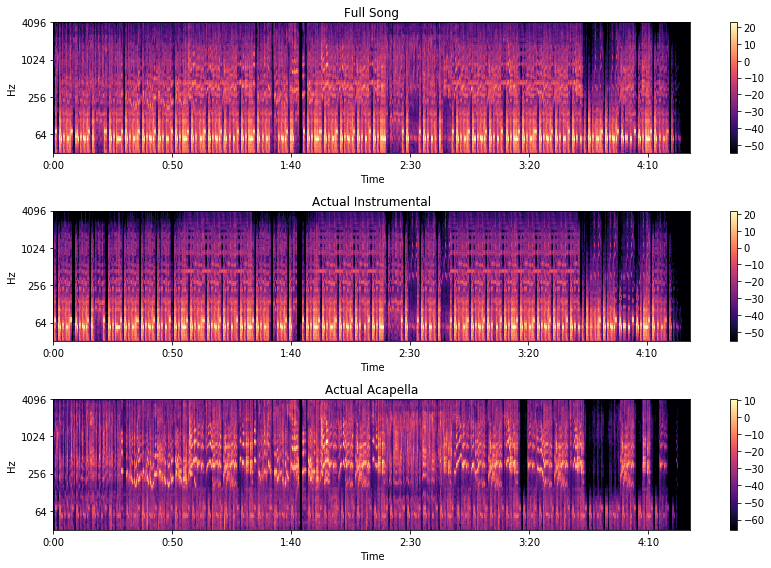

In [5]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
tempoI, beatsI = librosa.beat.beat_track(y=yI, sr=srI, trim=False)
tempoA, beatsA = librosa.beat.beat_track(y=yA, sr=srA, trim=False)

Csync = librosa.util.sync(C, beats, aggregate=np.median)
CsyncI = librosa.util.sync(CI, beatsI, aggregate=np.median)
CsyncA = librosa.util.sync(CA, beatsA, aggregate=np.median)

# For plotting purposes, we'll need the timing of the beats
# we fix_frames to include non-beat frames 0 and C.shape[1] (final frame)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                            x_min=0,
                                                            x_max=C.shape[1]),
                                    sr=sr)

librosa.display.specshow(Csync,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_times, cmap='magma')
plt.title('Full Song')
plt.colorbar()
plt.subplot(3, 1, 2)
beat_timesI = librosa.frames_to_time(librosa.util.fix_frames(beatsI,
                                                            x_min=0,
                                                            x_max=CI.shape[1]),
                                    sr=srI)

librosa.display.specshow(CsyncI,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_timesI, cmap='magma')
plt.title('Actual Instrumental')
plt.colorbar()
plt.subplot(3, 1, 3)
beat_timesA = librosa.frames_to_time(librosa.util.fix_frames(beatsA,
                                                            x_min=0,
                                                            x_max=CA.shape[1]),
                                    sr=srA)

librosa.display.specshow(CsyncA,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_timesA, cmap='magma')
plt.title('Actual Acapella')
plt.colorbar()
plt.tight_layout()

Let's build a weighted recurrence matrix using beat-synchronous CQT
(Equation 1)
width=3 prevents links within the same bar
mode='affinity' here implements S_rep (after Eq. 8)



In [6]:
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity',
                                      sym=True)
RI = librosa.segment.recurrence_matrix(CsyncI, width=3, mode='affinity',
                                      sym=True)
RA = librosa.segment.recurrence_matrix(CsyncA, width=3, mode='affinity',
                                      sym=True)

# Enhance diagonals with a median filter (Equation 2)
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)

Rf = df(R, size=(1, 7))
RfI = df(RI, size=(1, 7))
RfA = df(RA, size=(1, 7))

Now let's build the sequence matrix (S_loc) using mfcc-similarity

  $R_\text{path}[i, i\pm 1] = \exp(-\|C_i - C_{i\pm 1}\|^2 / \sigma^2)$

Here, we take $\sigma$ to be the median distance between successive beats.




In [7]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

mfccI = librosa.feature.mfcc(y=yI, sr=srI)
MsyncI = librosa.util.sync(mfccI, beatsI)

mfccA = librosa.feature.mfcc(y=yA, sr=srA)
MsyncA = librosa.util.sync(mfccA, beatsA)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
sigma = np.median(path_distance)
path_sim = np.exp(-path_distance / sigma)

path_distanceI = np.sum(np.diff(MsyncI, axis=1)**2, axis=0)
sigmaI = np.median(path_distanceI)
path_simI = np.exp(-path_distanceI / sigmaI)

path_distanceA = np.sum(np.diff(MsyncA, axis=1)**2, axis=0)
sigmaA = np.median(path_distanceA)
path_simA = np.exp(-path_distanceA / sigmaA)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)
R_pathI = np.diag(path_simI, k=1) + np.diag(path_simI, k=-1)
R_pathA = np.diag(path_simA, k=1) + np.diag(path_simA, k=-1)

And compute the balanced combination (Equations 6, 7, 9)



In [8]:
deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

deg_pathI = np.sum(R_pathI, axis=1)
deg_recI = np.sum(RfI, axis=1)

deg_pathA = np.sum(R_pathA, axis=1)
deg_recA = np.sum(RfA, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)
muI = deg_pathI.dot(deg_pathI + deg_recI) / np.sum((deg_pathI + deg_recI)**2)
muA = deg_pathA.dot(deg_pathA + deg_recA) / np.sum((deg_pathA + deg_recA)**2)

A = mu * Rf + (1 - mu) * R_path
AI = muI * RfI + (1 - muI) * R_pathI
AA = muA * RfA + (1 - muA) * R_pathA

Plot the resulting graphs (Figure 1, left and center)



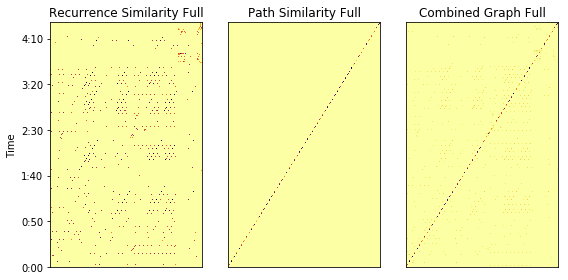

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time',
                         y_coords=beat_times)
plt.title('Recurrence Similarity Full')
plt.subplot(1, 3, 2)
librosa.display.specshow(R_path, cmap='inferno_r')
plt.title('Path Similarity Full')
plt.subplot(1, 3, 3)
librosa.display.specshow(A, cmap='inferno_r')
plt.title('Combined Graph Full')
plt.tight_layout()

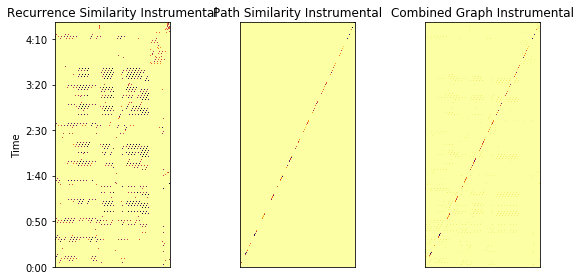

In [10]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(RfI, cmap='inferno_r', y_axis='time',
                         y_coords=beat_timesI)
plt.title('Recurrence Similarity Instrumental')
plt.subplot(1, 3, 2)
librosa.display.specshow(R_pathI, cmap='inferno_r')
plt.title('Path Similarity Instrumental')
plt.subplot(1, 3, 3)
librosa.display.specshow(AI, cmap='inferno_r')
plt.title('Combined Graph Instrumental')
plt.tight_layout()

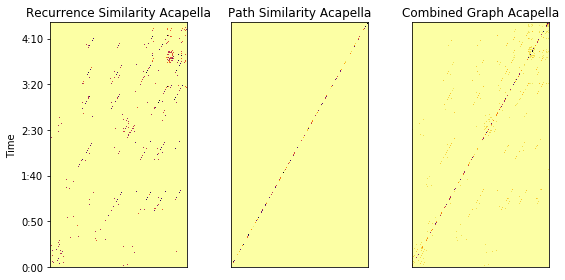

In [11]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(RfA, cmap='inferno_r', y_axis='time',
                         y_coords=beat_timesA)
plt.title('Recurrence Similarity Acapella')
plt.subplot(1, 3, 2)
librosa.display.specshow(R_pathI, cmap='inferno_r')
plt.title('Path Similarity Acapella')
plt.subplot(1, 3, 3)
librosa.display.specshow(AA, cmap='inferno_r')
plt.title('Combined Graph Acapella')
plt.tight_layout()

Now let's compute the normalized Laplacian (Eq. 10)



In [12]:
L = scipy.sparse.csgraph.laplacian(A, normed=True)
LI = scipy.sparse.csgraph.laplacian(AI, normed=True)
LA = scipy.sparse.csgraph.laplacian(AA, normed=True)

# and its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)
evalsI, evecsI = scipy.linalg.eigh(LI)
evalsA, evecsA = scipy.linalg.eigh(LA)

# We can clean this up further with a median filter.
# This can help smooth over small discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
evecsI = scipy.ndimage.median_filter(evecsI, size=(9, 1))
evecsA = scipy.ndimage.median_filter(evecsA, size=(9, 1))

# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5
CnormI = np.cumsum(evecsI**2, axis=1)**0.5
CnormA = np.cumsum(evecsA**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how the segmentation changes as you vary k

k = 5

X = evecs[:, :k] / Cnorm[:, k-1:k]
XI = evecsI[:, :k] / CnormI[:, k-1:k]
XA = evecsA[:, :k] / CnormA[:, k-1:k]

KM = sklearn.cluster.KMeans(n_clusters=k)

seg_ids = KM.fit_predict(X)
seg_idsI = KM.fit_predict(XI)
seg_idsA = KM.fit_predict(XA)

Let's use these k components to cluster beats into segments
(Algorithm 1)



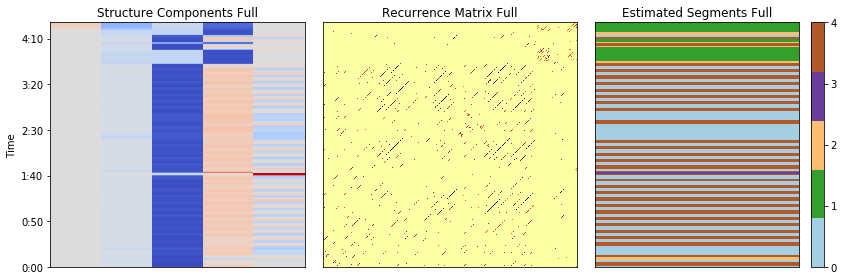

In [13]:
# Plot the resulting representation (Figure 1, center and right)
plt.figure(figsize=(12, 4))
colors = plt.get_cmap('Paired', k)

plt.subplot(1, 3, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence Matrix Full')
plt.subplot(1, 3, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times)
plt.title('Structure Components Full')
plt.subplot(1, 3, 3)
librosa.display.specshow(np.atleast_2d(seg_ids).T, cmap=colors)
plt.title('Estimated Segments Full')
plt.colorbar(ticks=range(k+1))
plt.tight_layout()

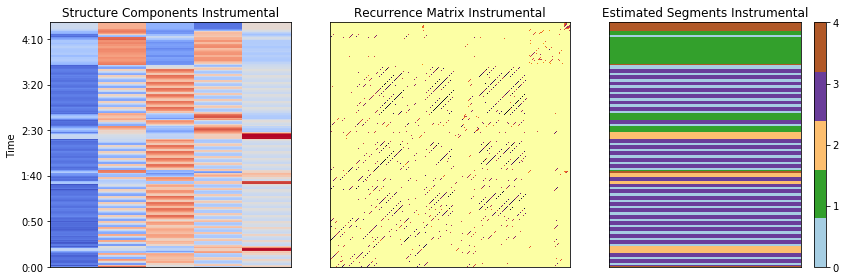

In [14]:
# Plot the resulting representation (Figure 1, center and right)
plt.figure(figsize=(12, 4))
colors = plt.get_cmap('Paired', k)
plt.subplot(1, 3, 2)
librosa.display.specshow(RfI, cmap='inferno_r')
plt.title('Recurrence Matrix Instrumental')
plt.subplot(1, 3, 1)
librosa.display.specshow(XI,
                         y_axis='time',
                         y_coords=beat_timesI)
plt.title('Structure Components Instrumental')
plt.subplot(1, 3, 3)
librosa.display.specshow(np.atleast_2d(seg_idsI).T, cmap=colors)
plt.title('Estimated Segments Instrumental')
plt.colorbar(ticks=range(k+1))
plt.tight_layout()

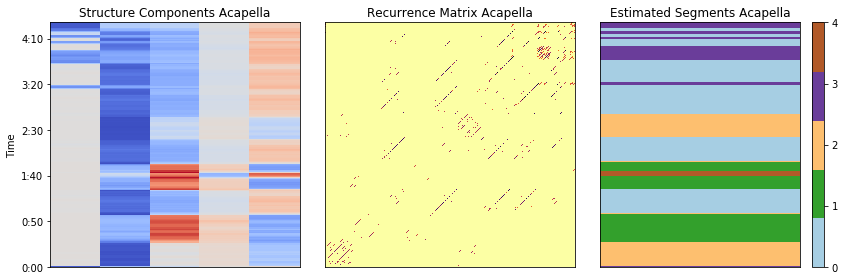

In [15]:
# Plot the resulting representation (Figure 1, center and right)
plt.figure(figsize=(12, 4))
colors = plt.get_cmap('Paired', k)
plt.subplot(1, 3, 2)
librosa.display.specshow(RfA, cmap='inferno_r')
plt.title('Recurrence Matrix Acapella')
plt.subplot(1, 3, 1)
librosa.display.specshow(XA,
                         y_axis='time',
                         y_coords=beat_timesA)
plt.title('Structure Components Acapella')
plt.subplot(1, 3, 3)
librosa.display.specshow(np.atleast_2d(seg_idsA).T, cmap=colors)
plt.title('Estimated Segments Acapella')
plt.colorbar(ticks=range(k+1))
plt.tight_layout()

Locate segment boundaries from the label sequence



In [16]:
bound_beats = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])
bound_beatsI = 1 + np.flatnonzero(seg_idsI[:-1] != seg_idsI[1:])
bound_beatsA = 1 + np.flatnonzero(seg_idsA[:-1] != seg_idsA[1:])
# Count beat 0 as a boundary
bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)
bound_beatsI = librosa.util.fix_frames(bound_beatsI, x_min=0)
bound_beatsA = librosa.util.fix_frames(bound_beatsA, x_min=0)
# Compute the segment label for each boundary
bound_segs = list(seg_ids[bound_beats])
bound_segsI = list(seg_idsI[bound_beatsI])
bound_segsA = list(seg_idsA[bound_beatsA])
# Convert beat indices to frames
bound_frames = beats[bound_beats]
bound_framesI = beatsI[bound_beatsI]
bound_framesA = beatsA[bound_beatsA]
# Make sure we cover to the end of the track
bound_frames = librosa.util.fix_frames(bound_frames,
                                       x_min=None,
                                       x_max=C.shape[1]-1)
bound_framesI = librosa.util.fix_frames(bound_framesI,
                                       x_min=None,
                                       x_max=CI.shape[1]-1)
bound_framesA = librosa.util.fix_frames(bound_framesA,
                                       x_min=None,
                                       x_max=CA.shape[1]-1)

And plot the final segmentation over original CQT



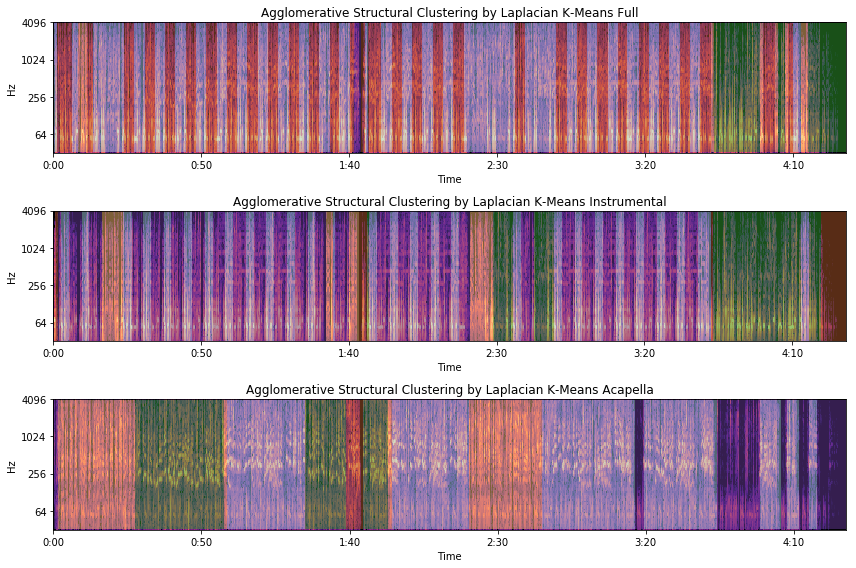

In [17]:
# sphinx_gallery_thumbnail_number = 5
import matplotlib.patches as patches

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
bound_times = librosa.frames_to_time(bound_frames)

freqs = librosa.cqt_frequencies(n_bins=C.shape[0],
                                fmin=librosa.note_to_hz('C1'))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr, x_axis='time', cmap='magma')

ax = plt.gca()

for interval, label in zip(zip(bound_times, bound_times[1:]), bound_segs):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]),
                                   interval[1] - interval[0],
                                   freqs[-1],
                                   facecolor=colors(label),
                                   alpha=0.50))
plt.title('Agglomerative Structural Clustering by Laplacian K-Means Full')

plt.subplot(3, 1, 2)
bound_timesI = librosa.frames_to_time(bound_framesI)

freqsI = librosa.cqt_frequencies(n_bins=CI.shape[0],
                                fmin=librosa.note_to_hz('C1'))
librosa.display.specshow(CI, y_axis='cqt_hz', sr=srI, x_axis='time', cmap='magma')

ax = plt.gca()

for interval, label in zip(zip(bound_timesI, bound_timesI[1:]), bound_segsI):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]),
                                   interval[1] - interval[0],
                                   freqs[-1],
                                   facecolor=colors(label),
                                   alpha=0.50))
plt.title('Agglomerative Structural Clustering by Laplacian K-Means Instrumental')

plt.subplot(3, 1, 3)
bound_timesA = librosa.frames_to_time(bound_framesA)

freqsA = librosa.cqt_frequencies(n_bins=CA.shape[0],
                                fmin=librosa.note_to_hz('C1'))
librosa.display.specshow(CA, y_axis='cqt_hz', sr=srA, x_axis='time', cmap='magma')

ax = plt.gca()

for interval, label in zip(zip(bound_timesA, bound_timesA[1:]), bound_segsA):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]),
                                   interval[1] - interval[0],
                                   freqs[-1],
                                   facecolor=colors(label),
                                   alpha=0.50))
plt.title('Agglomerative Structural Clustering by Laplacian K-Means Acapella')
plt.tight_layout()
plt.show()